# 1. Import related packages

In [0]:
%matplotlib inline
import time
import keras
import warnings
import numpy as np  
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras.optimizers import Adam
from keras.layers import Input, Dense
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_mldata
from keras.models import Sequential, Model
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC  

Using TensorFlow backend.


 # 2. Road data of MNIST 

## 1.1 Road the raw data

In [0]:
# load the fashion_mnist data and split it into train and test
(x_training, y_training), (x_test, y_test) = fashion_mnist.load_data()
# make a copy of label
label_train = y_training
label_test = y_test

## 1.2 Reshape the raw data

In [0]:
# reshape data to 784 dimension
original_data = np.reshape(x_training, (x_training.shape[0], x_training.shape[1] * x_training.shape[2]))
# nomalization
data_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] * x_test.shape[2])).astype('float32') / 255.
data_train = original_data.astype('float32') / 255

# 3. Methods of dimensionality reduction

## 3.1 PCA data dimensionality reduction

### Implement PCA dimensionality reduction

In [0]:
# PCA function
def pca_reduction(data_train,data_test,percentage):
    warnings.filterwarnings('ignore')
    new_data_train = data_train
    new_data_test = data_test
    new_pca = PCA(percentage) # retain how much similarity
    new_data_train = new_pca.fit_transform(new_data_train)
    new_data_test = new_pca.transform(new_data_test)
    return new_data_train, new_data_test

## 3.2 SVD data dimensionality reduction

### Implement SVD dimensionality reduction

In [0]:
# SVD function
def svd_reduction(train,test,num):
    svd = TruncatedSVD(n_components= num, algorithm='randomized')
    svd_data_train = svd.fit_transform(train)
    svd_data_test = svd.transform(test)
    return svd_data_train,svd_data_test,svd

## 3.3 Autoencoders data dimensionality reduction

### Implement autoencoders with different dimensions

In [0]:
def autoencoder_reduction(X_data,y_data,num):
    X_data = X_data - 0.5
    y_data = y_data - 0.5        
    X_data = X_data.reshape((X_data.shape[0], -1))
    y_data = y_data.reshape((y_data.shape[0], -1))


    encoding_dim = num
    
    # input placeholder
    input_img = Input(shape=(784,))

    # encoder layers
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(10, activation='relu')(encoded)
    encoder_output = Dense(encoding_dim)(encoded)

    # decoder layers
    decoded = Dense(10, activation='relu')(encoder_output)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='tanh')(decoded)

    # autoencoder model
    autoencoder = Model(input=input_img, output=decoded)

    # encoder model for plotting
    encoder = Model(input=input_img, output=encoder_output)

    # compile autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')

    # training
    autoencoder.fit(X_data, X_data,nb_epoch = 20, batch_size=256, shuffle=True)
    
    encoded_test = encoder.predict(y_data)
    encoded_train = encoder.predict(X_data)
    return encoded_train, encoded_test

# 4. KNN to the transformed data and K-Fold Cross Validation

In [0]:
# knn function used to make cross validation for selecting optimal parameter
def knn_valid(data,label):
    knn_time_start = time.time()
    k_range = range(1,20,2)  
    k_scores = []    
    for k in k_range:  
        knn = KNeighborsClassifier(n_neighbors=k,weights='uniform', algorithm='auto', leaf_size=30, p=2, metric_params=None, n_jobs=5)  
        scores = cross_val_score(knn, data, label, cv=10, scoring='accuracy')  
        k_scores.append(scores.mean())  
    print('validation done! Time elapsed: {:.6f} seconds'.format(time.time()-knn_time_start))

    # draw figure for comparison
    plt.plot(k_range, k_scores)
    plt.xlim(0,len(k_range)*2)
    plt.title("KNN Classifier")
    plt.xlabel('Value of K for KNN')  
    plt.ylabel('Cross-Validated Accuracy')  
    plt.show()  
    return  k_scores

# 5. Logistic Regression to the Transformed Data

In [0]:
# logistic regression function used to make cross validation for selecting optimal parameter
def lr_c_valid(data_train,label_train):
    lr_time_start = time.time()
    c_range = [1,20,40,60,80,100]  
    c_scores = []    
    for c in c_range:  
        logisticRegr = LogisticRegression(multi_class='auto',solver='lbfgs',C=c, n_jobs=10)  
        lr_scores = cross_val_score(logisticRegr, data_train, label_train, cv=10, scoring='accuracy')  
        c_scores.append(lr_scores.mean())  
    print('validation of LR done! Time elapsed: {:.6f} seconds'.format(time.time()-lr_time_start))
    # draw figure for comparison
    plt.plot(c_range, c_scores)
    plt.title("LR Classifier")
    plt.xlabel('Value of C for LR')  
    plt.ylabel('Cross-Validated Accuracy')  
    plt.show()  
      
    return  c_scores

# 6. Testing 

## 6.1 PCA Visualization

In [0]:
# Reduce data to 84 dims and retain 90% similarity with original data
pca_time_start = time.time()
pca_data_train,pca_data_test = pca_reduction(data_train,data_test,0.9)
print('PCA done! Time elapsed: {:.6f} seconds'.format(time.time()-pca_time_start))

PCA done! Time elapsed: 14.619150 seconds


## 6.2 SVD Visualization

In [0]:
# Reduce data to 84 dims and retain 90% similarity with original data
svd_time_start = time.time()
svd_data_train, svd_data_test,new_svd = svd_reduction(data_train,data_test,84)
print('SVD done! Time elapsed: {:.6f} seconds'.format(time.time()-svd_time_start))

SVD done! Time elapsed: 5.351847 seconds


## 6.3 Auto encoder Visualization

In [0]:
# Reduct data dimiension by auto encoder
encoded_train, encoded_test = autoencoder_reduction(data_train,data_test,84)

Epoch 1/20
60000/60000 [==============================] - 4s 70us/step - loss: 0.0466
Epoch 2/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.0259
Epoch 3/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0237
Epoch 4/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.0226
Epoch 5/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.0218
Epoch 6/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0213
Epoch 7/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.0209
Epoch 8/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.0206
Epoch 9/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.0203
Epoch 10/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.0201
Epoch 11/20
60000/60000 [==============================] - 4s 62us/step - loss: 0.0199
Epoch 12/20
60000/60000 [===========================

## 7. KNN and crossValidation

### 7.1 KNN with PCA cross validation

validation done! Time elapsed: 3316.269355 seconds


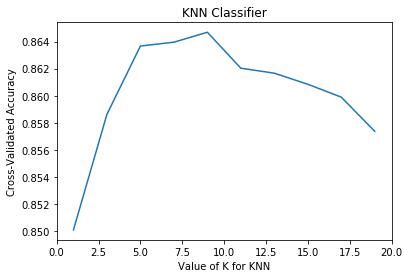

In [12]:
# call validation function of knn
k_val_pca_scores = knn_valid(pca_data_train,label_train)

In [15]:
k_val_pca_scores

[0.8501166666666669,
 0.8586333333333332,
 0.8636666666666667,
 0.86395,
 0.8646833333333334,
 0.8620333333333333,
 0.8616666666666667,
 0.8608499999999999,
 0.8599,
 0.8573833333333333]

In [16]:
max_score = max(k_val_pca_scores) # max mean 
best_k = k_val_pca_scores.index(max_score)*2 +1 # get k value
print(max_score,"Optimal parameter:",best_k)

0.8646833333333334 Optimal parameter: 9


In [0]:
# use the optimal parameter to construct model
new_pca_knn = KNeighborsClassifier(n_neighbors=9,weights='uniform', algorithm='auto', leaf_size=30, p=2, metric_params=None, n_jobs=5)

In [0]:
knn_pca_model = new_pca_knn.fit(pca_data_train,label_train) # check accuracy

In [0]:
new_pca_knn.score(pca_data_test,label_test) 

0.8615

### 7.2 KNN with SVD  cross validation

validation done! Time elapsed: 5035.351722 seconds


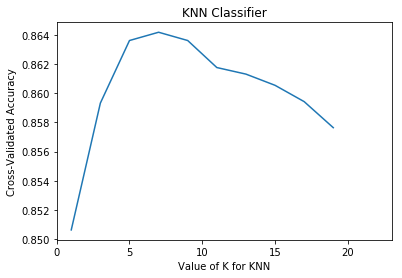

In [0]:
# SVD validation
k_val_svd_score = knn_valid(svd_data_train,label_train)

In [0]:
k_val_svd_score

[0.8506333333333332,
 0.8593166666666667,
 0.8635999999999999,
 0.8641666666666667,
 0.8636000000000001,
 0.86175,
 0.8613,
 0.8605333333333334,
 0.8594166666666666,
 0.8576333333333335]

In [0]:
# find max mean of accuracies and choose optimal K
max_score = max(k_val_svd_score)
best_k = k_val_svd_score.index(max_score)*2 +1
print(max_score,"Optimal parameter:",best_k)

0.8641666666666667 Optimal parameter: 7


In [0]:
new_svd_knn = KNeighborsClassifier(n_neighbors=7,weights='uniform', algorithm='auto', leaf_size=30, p=2, metric_params=None, n_jobs=5)

In [0]:
knn_svd_model = new_svd_knn.fit(svd_data_train,label_train)

In [0]:
new_svd_knn.score(svd_data_test,label_test) # optimal result

0.8611

### 7.3 KNN with Auto-encoder  cross validation

validation done! Time elapsed: 1733.345294 seconds


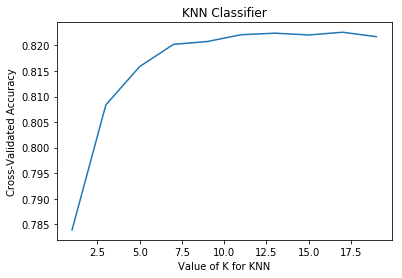

In [0]:
# knn validation with auto-encoder
k_val_encoder_score = knn_valid(encoded_train,label_train)

In [0]:
k_val_encoder_score

[0.7838999999999999,
 0.8083666666666666,
 0.8158666666666667,
 0.8202166666666667,
 0.8207666666666666,
 0.8221,
 0.8224,
 0.82205,
 0.8225833333333334,
 0.8217166666666668]

In [0]:
# find max mean of accuracies and best parameter
max_score = max(k_val_encoder_score)
best_k = k_val_encoder_score.index(max_score)*2+1
print(max_score,"Optimal parameter:",best_k)

0.8225833333333334 Optimal parameter: 17


In [0]:
new_encoder_knn = KNeighborsClassifier(n_neighbors=17,weights='uniform', algorithm='auto', leaf_size=30, p=2, metric_params=None, n_jobs=5)

In [0]:
new_encoder_knn.fit(encoded_train,label_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=5, n_neighbors=17, p=2,
                     weights='uniform')

In [0]:
# check optimal result
new_encoder_knn.score(encoded_test,label_test) 

0.8141

## 8. Logistic Regression and crossValidation

### 8.1 LR with PCA cross validation

validation of LR done! Time elapsed: 571.152779 seconds


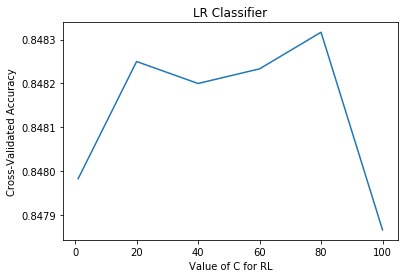

In [0]:
# calling logistic regression function
lr_val_c_scores = lr_c_valid(pca_data_train,label_train) 

In [0]:
lr_val_c_scores # mean of each accuracy

[0.8479833333333333,
 0.84825,
 0.8482000000000001,
 0.8482333333333333,
 0.8483166666666666,
 0.8478666666666668]

In [0]:
max_score = max(lr_val_c_scores)
best_c = lr_val_c_scores.index(max_score)*20
print(max_score,"Optimal parameter:",best_c)

0.8483166666666666 Optimal parameter: 80


In [0]:
new_lr = LogisticRegression(C=80,class_weight=None,n_jobs=10,solver='lbfgs',verbose=1)
new_lr.fit(pca_data_train,label_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   33.7s remaining:  2.2min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.1min finished


LogisticRegression(C=80, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [0]:
time_start = time.time()
print(new_lr.score(pca_data_test,label_test))
print('Time elapsed: {:.6f} seconds'.format(time.time()-time_start))

0.8342
Time elapsed: 0.010429 seconds


### 8.2 LR with SVD cross validation

validation of LR done! Time elapsed: 583.827801 seconds


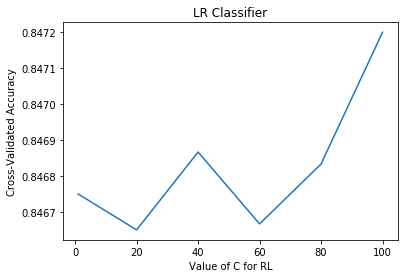

In [0]:
lr_svd_scores = lr_c_valid(svd_data_train,label_train) # calling LR validation

In [0]:
lr_svd_scores

[0.8467499999999999,
 0.84665,
 0.8468666666666668,
 0.8466666666666667,
 0.8468333333333332,
 0.8472]

In [0]:
max_score = max(lr_svd_scores)
best_c = lr_svd_scores.index(max_score)*20
print(max_score,"Optimal parameter:",best_c)

0.8472 Optimal parameter: 100


In [0]:
# fit model
new_lr_svd = LogisticRegression(C=100,class_weight=None,n_jobs=10,solver='lbfgs',verbose=1)
new_lr_svd.fit(svd_data_train,label_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   31.8s remaining:  2.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.0min finished


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [0]:
time_start = time.time()
print(new_lr_svd.score(svd_data_test,label_test)) # check result
print('Time elapsed: {:.6f} seconds'.format(time.time()-time_start)) 

0.8353
Time elapsed: 0.016880 seconds


### 8.3 LR with auto encoder cross validation

validation of LR done! Time elapsed: 580.460504 seconds


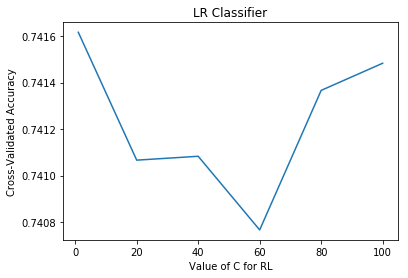

In [0]:
lr_encoded_scores = lr_c_valid(encoded_train,label_train)

In [0]:
lr_encoded_scores

[0.7416166666666667,
 0.7410666666666665,
 0.7410833333333333,
 0.7407666666666667,
 0.7413666666666667,
 0.7414833333333333]

In [0]:
max_score = max(lr_encoded_scores)
best_c = lr_encoded_scores.index(max_score)*20
print(max_score,"Optimal parameter:",best_c)

0.7416166666666667 Optimal parameter: 0


In [0]:
new_lr_encoded = LogisticRegression(C=100,class_weight=None,n_jobs=10,solver='lbfgs',verbose=1)
new_lr_encoded.fit(encoded_train,label_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   31.4s remaining:  2.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.0min finished


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [0]:
time_start = time.time()
print(new_lr_encoded.score(encoded_test,label_test))
print('Time elapsed: {:.6f} seconds'.format(time.time()-time_start))

0.7117
Time elapsed: 0.022159 seconds


## 9. Random Forest and crossValidation

In [0]:
def RandomForest_valid(data_train,label_train): # validation funtion for random forest
    time_start = time.time()
    rfc_val_scores = []
    range_n = [10,50,100]
    for i in range_n:
      rfc = RandomForestClassifier(n_estimators=i,
                                   random_state=50,
                                  n_jobs=50)
      rfc_val_scores.append(cross_val_score(rfc,data_train,label_train,cv=10).mean())
    print('validation of random forest done! Time elapsed: {:.6f} seconds'.format(time.time()-time_start))

    plt.plot(range_n, rfc_val_scores)
    plt.title("Random Forest Classifier")
    plt.xlabel('Value of n_estimator')  
    plt.ylabel('Cross-Validated Accuracy')  
    plt.show()
    return  rfc_val_scores

### 9.1 RF with PCA cross validation

validation of random forest done! Time elapsed: 629.233764 seconds


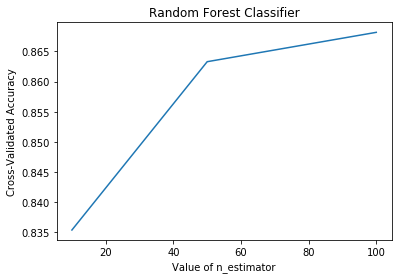

In [0]:
rfc_val_pca_scores = RandomForest_valid(pca_data_train,label_train) # run RF

In [0]:
rfc_val_pca_scores

[0.8354000000000001, 0.8633000000000001, 0.8681666666666666]

In [0]:
max_score = max(rfc_val_pca_scores)
best_n_estimators = rfc_val_pca_scores.index(max_score)*50
print(max_score,"Optimal parameter:",best_n_estimators)

0.8681666666666666 Optimal parameter: 100


In [0]:
rfc_pca = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=10)
time_start = time.time()
rfc_pca.fit(pca_data_train, label_train)
print('Model training time elapsed: {:.6f} seconds'.format(time.time()-time_start))

Model training time elapsed: 53.225708 seconds


In [0]:
time_start = time.time()
print(rfc_pca.score(pca_data_test,label_test)) # check the result
print('Time elapsed: {:.6f} seconds'.format(time.time()-time_start))

0.8614
Time elapsed: 0.236405 seconds


### 9.2 RF with SVD cross validation

validation of random forest done! Time elapsed: 615.575219 seconds


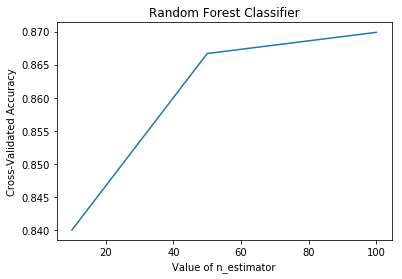

In [0]:
# calling Random forest validation function
rfc_val_svd_scores = RandomForest_valid(svd_data_train,label_train)

In [0]:
rfc_val_svd_scores

[0.84005, 0.8666833333333333, 0.8698833333333333]

In [0]:
# find max mean accuracy and best n_estimator
max_score = max(rfc_val_svd_scores)
best_n_estimators = rfc_val_svd_scores.index(max_score)*50
print(max_score,best_n_estimators)

0.8698833333333333 100


In [0]:
rfc_svd = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=10)
time_start = time.time()
rfc_svd.fit(svd_data_train, label_train)
print('Model training time elapsed: {:.6f} seconds'.format(time.time()-time_start))

Model training time elapsed: 52.844728 seconds


In [0]:
time_start = time.time()
print(rfc_svd.score(svd_data_test,label_test))
print('Time elapsed: {:.6f} seconds'.format(time.time()-time_start))

0.864
Time elapsed: 0.351059 seconds


### 9. 3  RF with auto encoder cross validation

validation of random forest done! Time elapsed: 620.726569 seconds


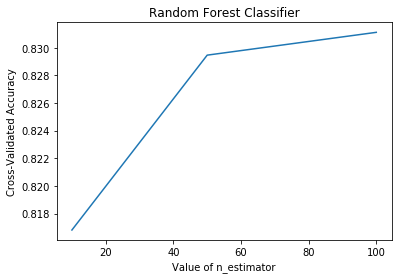

In [0]:
# calling random forest validation function
rfc_val_encoded_scores = RandomForest_valid(encoded_train,label_train)

In [0]:
rfc_val_encoded_scores

[0.8168166666666666, 0.8294666666666666, 0.8311166666666667]

In [0]:
# output max and beset estimators
max_score = max(rfc_val_encoded_scores)
best_n_estimators = rfc_val_encoded_scores.index(max_score)*50
print(max_score,best_n_estimators)

0.8311166666666667 100


In [0]:
# output construction of model time
rfc_encoded = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=10)
time_start = time.time()
rfc_encoded.fit(encoded_train, label_train)
print('Model training time elapsed: {:.6f} seconds'.format(time.time()-time_start))

Model training time elapsed: 42.972331 seconds


In [0]:
# output prdicted time and accuracy
time_start = time.time()
print(rfc_encoded.score(encoded_test,label_test))
print('Time elapsed: {:.6f} seconds'.format(time.time()-time_start))

0.8219
Time elapsed: 0.218380 seconds


## 10. LinearSVC and crossValidation

### 10.1 LSVC with PCA cross validation

In [0]:
# use Grid search to do the K fold task make the cross validation
parameter_grid = {'C':[1,10],'loss':['hinge'],'penalty':['l2']},
lsvc = LinearSVC(multi_class='ovr',
                     random_state=10,
                     dual=True)
GS = GridSearchCV(lsvc,parameter_grid,cv = 10,return_train_score =True,n_jobs=50)
GS.fit(pca_data_train,label_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=10, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=50,
       param_grid=({'C': [1, 10], 'loss': ['hinge'], 'penalty': ['l2']},),
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [0]:
lsvc = GS.best_estimator_ # find beset paramaters
lsvc.fit(pca_data_train,label_train) # fit PCA train data

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=10, tol=0.0001, verbose=0)

In [0]:
lsvc.score(pca_data_test,label_test) # test the result 83.52%.

0.8352

### 10.2 LSVC with SVD cross validation

In [0]:
lsvc = GS.best_estimator_ 
lsvc.fit(svd_data_train,label_train) # fit SVD train data

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=10, tol=0.0001, verbose=0)

In [0]:
lsvc.score(svd_data_test,label_test) # test the result 83.54%.

0.8354

### 10.3 LSVC with auto encoder cross validation

In [0]:
lsvc = GS.best_estimator_
lsvc.fit(encoded_train,label_train) # fit encoded train data 

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=10, tol=0.0001, verbose=0)

In [0]:
lsvc.score(encoded_test,label_test) # test the result  68.49%.

0.6849